## Import Dependencies

In [2]:
from skimage.metrics import structural_similarity 
import matplotlib.pyplot as plt
import numpy as np
import cv2

import torch

## Downloading YOLO

In [3]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
model

Using cache found in /Users/mohamedmafaz/.cache/torch/hub/ultralytics_yolov5_master
requirements: Ultralytics requirements ['gitpython>=3.1.30', 'setuptools>=65.5.1'] not found, attempting AutoUpdate...
/bin/sh: pip: command not found
requirements: ❌ Command 'pip install --no-cache "gitpython>=3.1.30" "setuptools>=65.5.1" ' returned non-zero exit status 127.
YOLOv5 🚀 2023-9-24 Python-3.11.5 torch-2.0.1 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  

# Dealing with Reidentification

In [106]:
def orb_sim(img1, img2):
  # SIFT is no longer available in cv2 so using ORB
  orb = cv2.ORB_create()

  # detect keypoints and descriptors
  kp_a, desc_a = orb.detectAndCompute(img1, None)
  kp_b, desc_b = orb.detectAndCompute(img2, None)

  # define the bruteforce matcher object
  bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    
  #perform matches. 
  matches = bf.match(desc_a, desc_b)
  #Look for similar regions with distance < 50. Goes from 0 to 100 so pick a number between.
  similar_regions = [i for i in matches if i.distance < 40]  
  if len(matches) == 0:
    return 0
  return len(similar_regions) / len(matches)


#Needs images to be same dimensions
def structural_sim(img1, img2):

  sim, diff = structural_similarity(img1, img2, full=True)
  return sim

img00 = cv2.imread('/Users/mohamedmafaz/Desktop/Multicamera tracking/Diff_views/Output1.png', 0)
img01 = cv2.imread('/Users/mohamedmafaz/Desktop/Multicamera tracking/Diff_views/Output2.png', 0)



orb_similarity = orb_sim(img00, img01)  #1.0 means identical. Lower = not similar

print("Similarity using ORB is: ", orb_similarity)

Similarity using ORB is:  0.9298245614035088


## Checking Orb similarities Between current frame and previous frame (withint a cuttoff)

In [107]:
for frame in range(1,230):
        # /Users/mohamedmafaz/Desktop/Multicamera tracking/Cam1/cam_10001.png
        link1 = f"/Users/mohamedmafaz/Desktop/Multicamera tracking/Cam1/cam_1{frame:04d}.png"
        link2 = f"/Users/mohamedmafaz/Desktop/Multicamera tracking/Cam1/cam_1{frame+1:04d}.png"
        img1 = cv2.imread(link1 , 0)
        img2 = cv2.imread(link2 , 0)
        result1 = model(img1)
        result2 = model(img2)

        xyxy1 = []
        xyxy2 = []

        if result1.xyxy[0].shape[0] != 0 and result2.xyxy[0].shape[0] != 0:
                for i in result1.xyxy[0][0][:4]:
                        xyxy1.append(int(i))
                for i in result2.xyxy[0][0][:4]:
                        xyxy2.append(int(i))

                img1_cropped = (img1[xyxy1[1] - 50 : xyxy1[3] + 50 , xyxy1[0] - 50 : xyxy1[2] + 50])
                img2_cropped = (img2[xyxy2[1] - 50 : xyxy2[3] + 50 , xyxy2[0] - 50 : xyxy2[2] + 50])

                orb_similarity = orb_sim(img1_cropped, img2_cropped)
                print(f"Similarity using ORB is for frame {frame} and {frame+1} : {orb_similarity}")
        

Similarity using ORB is for frame 1 and 2 : 0.926605504587156
Similarity using ORB is for frame 6 and 7 : 0.8804347826086957
Similarity using ORB is for frame 17 and 18 : 0.9108910891089109
Similarity using ORB is for frame 18 and 19 : 0.9158878504672897
Similarity using ORB is for frame 19 and 20 : 0.9105691056910569
Similarity using ORB is for frame 20 and 21 : 0.9298245614035088
Similarity using ORB is for frame 21 and 22 : 0.9099099099099099
Similarity using ORB is for frame 22 and 23 : 0.8956521739130435
Similarity using ORB is for frame 23 and 24 : 0.9312977099236641
Similarity using ORB is for frame 26 and 27 : 0.9338842975206612
Similarity using ORB is for frame 27 and 28 : 0.925
Similarity using ORB is for frame 28 and 29 : 0.9206349206349206
Similarity using ORB is for frame 29 and 30 : 0.9416666666666667
Similarity using ORB is for frame 30 and 31 : 0.9107142857142857
Similarity using ORB is for frame 31 and 32 : 0.8910891089108911
Similarity using ORB is for frame 35 and 36

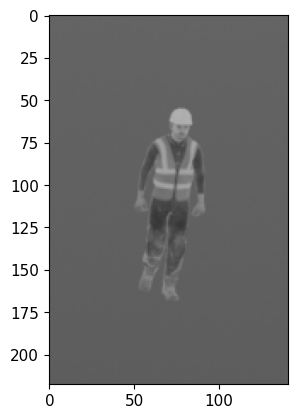

In [91]:
plt.imshow(img1_cropped)